In [360]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [361]:
data = pd.read_csv('cmake-build-debug/neuton_rafson.csv', header=None)

In [362]:
#data.columns = ['x', 'y', 'f-value']

In [363]:
data

,0,1,2
0,8.00000,8.00000,56049.300000
1,7.93400,7.73600,50541.700000
2,7.81558,7.58735,45645.800000
3,7.68417,7.46790,41239.100000
4,7.54565,7.36477,37264.800000
...,...,...,...
2848,-8.99509,4.00059,-0.735757
2849,-8.99510,4.00059,-0.735757
2850,-8.99510,4.00059,-0.735757
2851,-8.99511,4.00058,-0.735757


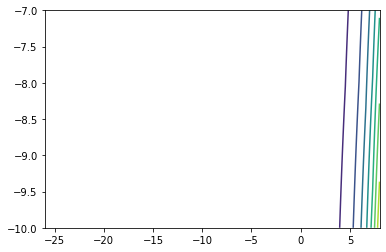

In [364]:
x, y = np.mgrid[-26:8:50j,
                -10:-7:50j]

z = np.exp(3.5)*np.exp(x/2)*(x + y**2 - 8*y + 23)

fig, ax = plt.subplots()

ax.contour(x, y, z)
for i in range(data.shape[0]-1):
    plt.arrow(data[0][i], data[1][i], data[0][i+1] - data[0][i], data[1][i+1] - data[1][i], width=0.04)

plt.show()

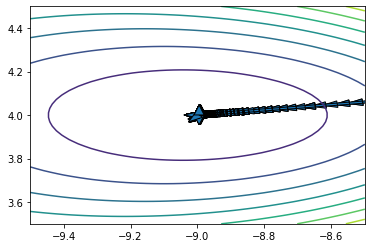

In [365]:
x, y = np.mgrid[-9.5:-8.5:50j,
                3.5:4.5:50j]

z = np.exp(3.5)*np.exp(x/2)*(x + y**2 - 8*y + 23)

fig, ax = plt.subplots()

ax.contour(x, y, z)
for i in range(data.shape[0]-1):
    plt.arrow(data[0][i], data[1][i], data[0][i+1] - data[0][i], data[1][i+1] - data[1][i], width=0.01)

plt.show()